In [1]:
!pip install keras==2.13.1 tensorflow==2.13.0 tensorflow-datasets==4.9.2
!pip install opendatasets

import gc
gc.collect()

try:
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn
except:
    !pip -q install keras==2.13.1 tensorflow==2.13.0 tensorflow-datasets==4.9.2 matplotlib numpy pillow scikit-learn
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn

try:
    import cv2
except:
    !pip -q install opencv-python
    import cv2
import os
import pandas as pd
import numpy as np
try:
    import torch
    import torchvision.transforms
except:
    !pip install torch torchvision
    import torch
    import torchvision.transforms

import platform

/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
log_root = "."
def is_running_in_colab():
  return 'google.colab' in sys.modules

if is_running_in_colab():
    print("Running in Colab")
    

    # Upload the kaggle.json file
    if not os.path.exists('~/.kaggle/kaggle.json'):
      print("\nUpload 'kaggle.json' file:")
      from google.colab import files
      files.upload()
      
      # Make directory named kaggle and copy kaggle.json file there
      !mkdir -p ~/.kaggle
      !cp kaggle.json ~/.kaggle/
      
      # Change the permissions of the file
      !chmod 600 ~/.kaggle/kaggle.json
    
    # Download the dataset
    import opendatasets as od

    # Replace with the actual Kaggle dataset URL
    print("Downloading OASIS dataset...")
    dataset_url = 'https://www.kaggle.com/datasets/ninadaithal/imagesoasis' 
    od.download(dataset_url)
    if not os.path.exists(r"/content/imagesoasis"):
        print("Dataset '/content/imagesoasis' not found. exiting...")
    # connect google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    log_root = '/content/gdrive/MyDrive/OASIS_results'
else:
    print("Not running in Colab")


Not running in Colab


# Dataset Selection

In [3]:
# DO NOT TOUCH BELOW ==================================
AUTO_SELECT = -1
FULL_DATASET = 0
FULL_BINARY_DATASET = 1
MY_DATASET = 2
MY_BIN_DATASET = 3
# DO NOT TOUCH - END ===================================

# select dataset
SELECTED_DATASET = AUTO_SELECT # CHANGE HERE

if SELECTED_DATASET == AUTO_SELECT:
    print(f"Selecting dataset automatically based on platform = '{platform.system()}'...")
    if platform.system() == "Windows":
        SELECTED_DATASET = FULL_DATASET
    elif platform.system() == "Darwin":
        SELECTED_DATASET = MY_DATASET
    else:
        if is_running_in_colab():
            print("Google collab is detected, running on full scale dataset.")
            SELECTED_DATASET = FULL_DATASET
        else:
            raise Exception("{SELECTED_DATASET=AUTO_SELECT} is not supported for this platform.")
    print("DONE")


# DO NOT TOUCH BELOW ==================================
if is_running_in_colab():
    FULL_DATASET_PATH = r"/content/imagesoasis/Data"
else:
    FULL_DATASET_PATH = r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset\OASIS dataset\Data'
FULL_BINARY_DATASET_PATH = r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset Binary\OASIS dataset\Data'
MY_DATASET_PATH = r'/Users/soumensardar/Downloads/OASIS/'
MY_DATASET_BINARY_PATH = r'/Users/soumensardar/Downloads/OASIS-binary/'

# while adding more datasets, make sure to add tflog directory
datasetdir, dataset_name =[  (FULL_DATASET_PATH, 'tflogs_mvcnn'),
                             (FULL_BINARY_DATASET_PATH, 'tflogs_binary_mvcnn'),
                             (MY_DATASET_PATH, 'tflogs_mvcnn'),
                             (MY_DATASET_BINARY_PATH, 'tflogs_binary_mvcnn'),
                    ][SELECTED_DATASET]
# DO NOT TOUCH - END ===================================
assert os.path.exists(datasetdir), f"Dataset path is incorrect {datasetdir}"
datasetdir, dataset_name

Selecting dataset automatically based on platform = 'Darwin'...
DONE


('/Users/soumensardar/Downloads/OASIS/', 'tflogs_mvcnn')

# Test Image selection

In [4]:
TEST_IMG_PATH, TEST_IMG_LABEL = [
(f'{datasetdir}/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', 'Mild_Dementia'),
(f'{datasetdir}/1. Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', '1. Mild_Dementia'),
(f'{datasetdir}/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', 'Mild Dementia'),
(f'{datasetdir}/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', '1. Mild Dementia'),
][SELECTED_DATASET]
import os
assert os.path.exists(TEST_IMG_PATH), f"Test image path is incorrect {TEST_IMG_PATH}"
TEST_IMG_PATH, TEST_IMG_LABEL

('/Users/soumensardar/Downloads/OASIS//Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg',
 'Mild Dementia')

In [5]:
import os, json
def get_experiment_details(dataset, model, ts):
    exp_asset_dir = f"{log_root}/results/{dataset}/{model}/{ts}"
    assert os.path.exists(exp_asset_dir), f"Experiment does not exist '{exp_asset_dir}'"
    checkpoint_model_dir = None
    with open(exp_asset_dir + "/currentepoch.txt") as fp:
        last_epoch = int(fp.read().strip())
        checkpoint_model_dir = exp_asset_dir + f"/models/epoch=%02d{model_ext}"%last_epoch
        assert os.path.exists(checkpoint_model_dir), f"Unable to find the last checkpoint file {checkpoint_model_dir}"
    best_model_dir = exp_asset_dir + f"/models/best-model{model_ext}"
    if not os.path.exists(best_model_dir):
        best_model_dir = None

    best_model_info = None
    if os.path.exists(exp_asset_dir + "/bestvalue.json"):
        with open(exp_asset_dir + "/bestvalue.json") as fp:
            best_model_info = json.load(fp)
        
    return dict(last_epoch=last_epoch, 
                best_checkpoint=best_model_dir, 
                last_checkpoint=checkpoint_model_dir,
                best_model_info=best_model_info,
                project_dir=exp_asset_dir)

# <font color='red'>Hyperparameters

In [46]:
random_seed=37
resume_training_timestamp = None # CHANGE HERE
ablation = False

max_epoch = 50 # CHANGE HERE
batch_size = 13
image_size = 224
volume_depth = 61 # 61
ablation_study_size = 0

if ablation:
    max_epoch = 2 # CHANGE HERE
    batch_size = 2
    image_size = 128
    volume_depth = 3 # 61
    ablation_study_size = batch_size * 50 # CHANGE HERE

color_mode = 'rgb'
n_ch = dict(rgb=3, grayscale=1)[color_mode]
monitor = "accuracy"
initial_threshold = 0.5
mode="max"
freq="epoch"
initial_epoch=0
precision = 32 # 16 bits or 32 bits
trainable = True
distributed = False
devices = ['CPU:0', 'GPU:0']
learning_rate = 0.001
lr_schedular = False
early_stop = True
enable_class_weight = False
model_ext = ".tf"
cache_file_name_fmt = f"oasis_cache_{batch_size:03}{volume_depth:03}{image_size:03}{n_ch:03}"

if not is_running_in_colab():
    distributed = False

task_type = "categorical" # "binary"
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions
if task_type == "binary":
    activation = "sigmoid"
    loss_function = "binary_crossentropy"
else:
    activation = "softmax"
    loss_function = "categorical_crossentropy"

resume_checkpoint_path = None
# Link: https://keras.io/api/applications/
model_name="MultiViewMobileNet" # CHANGE HERE !!!!!!!
# add a comment about what changes you have done just now before running the training
what_changed = f"Training with {model_name=} {task_type=} {lr_schedular=} {activation=} {loss_function=} {ablation_study_size=}"
print(f"{what_changed=}")
cache_file_name_fmt

what_changed="Training with model_name='MultiViewMobileNet' task_type='categorical' lr_schedular=False activation='softmax' loss_function='categorical_crossentropy' ablation_study_size=0"


'oasis_cache_013061224003'

In [47]:
# Learning rate schedular callback
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.02
  if epoch > 5:
    learning_rate = 0.01
  if epoch > 10:
    learning_rate = 0.0001
  if epoch > 15:
    learning_rate = 0.00001

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [48]:
if resume_training_timestamp:
    print(f"Trying to resume from checkpoint... {resume_training_timestamp}")
    d = get_experiment_details(dataset_name, model_name, resume_training_timestamp)
    initial_epoch = d['last_epoch']
    resume_checkpoint_path = d['last_checkpoint']
    assert os.path.exists(resume_checkpoint_path), f"Unable to resume training from '{d['project_dir']}'."
    best_model_info = d['best_model_info']
    if best_model_info:
        print("Updating the metric monitoring parameters before resuming the checkpoint")
        monitor = best_model_info['monitor']
        initial_threshold = best_model_info['value']
        mode=best_model_info['mode']
        freq=best_model_info['frequency']
    print(f"Resuming checkpoint form epoch={initial_epoch}.")
# =====================================================


def save_hparams():
    hyprams = dict(
            timestamp = timestamp,
            what_changed=what_changed,
            random_state=random_seed,
            max_epoch=max_epoch,
            batch_size=batch_size,
            image_size=image_size,
            num_channels=n_ch,
            metrics=str(metrics),
            loss_function=loss_function,
            monitoring=dict(monitor = monitor, initial_threshold = initial_threshold, mode=mode),
            resume_training_timestamp=resume_training_timestamp,
            initial_epoch=initial_epoch,
            model_name=model_name,
            optimizer=optimizer.name,
            learning_rate=learning_rate,
            lr_schedular=lr_schedular,
        )
    import json 
    log("Saving hyperparameters.")
    print(hyprams)
    # Convert and write JSON object to file
    with open(f"{artifact_root}/hyperparams.json", "w") as outfile: 
        json.dump(hyprams, outfile, indent=4)
    file_writer = tf.summary.create_file_writer(tf_log_dir + "/hparams")
    with file_writer.as_default():
        tf.summary.text("hyperparams.json", f"{artifact_root}/hyperparams.json", step=0)
        for k, v in hyprams.items():
            if isinstance(v, int):
                tf.summary.scalar(k, v, step=0)
            elif isinstance(v, float):
                tf.summary.scalar(k, v, step=0)
            else:
                tf.summary.text(k, str(v), step=0)

# Prepare `log-artifact` directory

In [49]:
import pathlib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if resume_training_timestamp:
    print("Resume timestamp", resume_training_timestamp)
    timestamp = resume_training_timestamp
unique_dir = f"{model_name}/{timestamp}"
tf_log_dir = f"{log_root}/results/{dataset_name}/{unique_dir}"
tf_log_img_dir = f"{log_root}/results/{dataset_name}/images"
artifact_root  = f"{log_root}/results/{dataset_name}/{unique_dir}"
pathlib.Path(artifact_root).mkdir(parents=True, exist_ok=True)
pathlib.Path(tf_log_dir).mkdir(parents=True, exist_ok=True)

def log(*args, **kwargs):
    time = False
    if "time" in kwargs.keys():
        time = kwargs["time"]
        del kwargs["time"]
    if time:
        time = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
        a = list(args)
        a.append(time)
        args = tuple(a)
    print(*args, **kwargs)
    with open(f"{artifact_root}/additional_logs.txt", "a") as fp:
        kwargs["file"] = fp
        kwargs["flush"] = True
        print(*args, **kwargs)
log(f"Experiment path: '{artifact_root}'")

Experiment path: './results/tflogs_mvcnn/MultiViewMobileNet/20250110-115812'


# <font color='red'>Training Resume Timestamp
## Use this `timestamp` to update `resume_training_timestamp` variable

In [50]:
log(f"Resume timestamp: '{timestamp}'")

Resume timestamp: '20250110-115812'


# setting random seed

In [51]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Loading multiview-datasets

In [55]:
import os
import pathlib
import random
import warnings
import random
from collections import defaultdict
        
import cv2
import numpy as np
import tensorflow as tf
import torchvision.transforms
from torch.utils.data import Dataset


class OASISTorchDataset(Dataset):
    BINARY_TASK = "binary"
    CATEGORY_TASK = "categorical"
    VOLUME_DEPTH = 61  # KNOWN DURING EDA: per patient we have 61 MRI slices

    def get_volume_for_image(self, oasis_image_path):
        """
        For a given image this function automatically determine the slices and return the volume and actual label
        :param oasis_image_path:
        :return:
        """

        oasis_image_path = pathlib.Path(oasis_image_path)
        class_name = oasis_image_path.parent.name
        # OAS1_0001_MR1_mpr-1_101.jpg
        fp, sp = oasis_image_path.name.split("-")  # [OAS1_0001_MR1_mpr, 1_101.jpg]
        spfp, spsp = sp.split("_")  # [1, 101.jpg]
        pattern = fp + "-" + spfp + "*"
        images = list(oasis_image_path.parent.glob(pattern))
        images = self._sample_from(images, OASISTorchDataset.VOLUME_DEPTH)
        lbl = self.encode_labels(class_name)
        return self.load_volume(images), class_name, lbl

    def __init__(self, path, task_type, image_size, transforms, split_name, batch_size, ablation=0, nch=3, seed=37,
                 splits=(70, 20, 10),
                 class_names=None,
                 dtype="float32", verbose=0):
        assert len(image_size) == 2, "Image size must be a tuple of two integers"
        assert split_name in ("train", "validation", "test")
        assert nch in (1, 3), "Supported channels are 1(greyscale) and 3(rgb)"
        assert len(splits) == 3 and sum(
            splits) == 100, f"train-validation-test splits must accumulate to 100, but {splits=} given."
        self.path = pathlib.Path(path)
        self.verbose = verbose
        # get class names
        self.classnames = self._load_class_names()
        if class_names is not None:
            self.classnames = [c for c in self.classnames if c in class_names]
        if task_type == self.BINARY_TASK and len(self.classnames) >= 2 and class_names is None:
            raise Exception(f"When `class_names` is not specified, "
                            f"only 2 classes are allowed in the data-directory, but {len(self.classnames)} found.")
        self.num_classes = len(self.classnames)
        if task_type == self.BINARY_TASK:
            self.num_classes = 1

        self.image_size = image_size
        self.dtype = dtype
        self.batch_size = batch_size
        self.transforms = transforms if transforms else torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0., std=1.),
        ])
        self.split_name = split_name
        self.task_type = task_type
        self.nch = nch
        self.splits = splits
        self.items = []
        self.ablation = ablation
        # load dataset
        self._load(seed)

    def _load_class_names(self):
        return [i for i in os.listdir(self.path) if i != ".DS_Store"]

    def _group_images_by_subject(self, image_dir):
        """Groups images by subject ID based on their filenames.
        Args:
            image_dir: Path to the directory containing the images.
        Returns:
            A dictionary where keys are subject IDs and values are lists of image filenames.
        """
        image_files = os.listdir(image_dir)
        subject_groups = {}
        for filename in image_files:
            # Extract subject ID from the filename (adjust the pattern as needed)
            # OAS1_0001_MR1_mpr-1_101.jpg
            subject_id = "_".join(filename.split('_')[0:-1])
            if subject_id not in subject_groups:
                subject_groups[subject_id] = []
            subject_groups[subject_id].append(os.path.join(image_dir, filename))
        if self.verbose:
            print("For", len(subject_groups.keys()), "patients,", len(image_files),
                  f"images scanned from '{image_dir}'")
        return subject_groups

    def item_generator(self):
        """
        :return: yield MRI slices as list and encoded label
        """
        for class_dir in self.classnames:
            grouped_files = self._group_images_by_subject((self.path / class_dir).resolve())
            for slices, label in zip(grouped_files.values(), [class_dir] * len(grouped_files.values())):
                lbl = self.encode_labels(label)
                yield self._sample_from(slices, OASISTorchDataset.VOLUME_DEPTH), lbl

    @staticmethod
    def _sample_from(lst, n):
        if n > len(lst):
            raise ValueError("Sample size cannot be greater than the list size.")

            # Calculate step size for approximately even distribution
        step_size = len(lst) // n

        # Generate indices with approximately even spacing
        indices = [i * step_size for i in range(n)]

        # Adjust last index to ensure it's within bounds
        indices[-1] = min(indices[-1], len(lst) - 1)
        return [lst[i] for i in indices]

    def encode_labels(self, labels):
        """
        :param labels: this could be a string or list of strings
        :return: encoded binary tensor of [1,0,1,...] or [[0,1],[1,0],[0,1],...]
                for categorical
        """
        is_one_element = False
        if isinstance(labels, str):
            labels = [labels]
            is_one_element = True
        enc_label = []
        for lbl in labels:
            if lbl not in self.classnames:
                warnings.warn(f"'{lbl}' label is unknown")
            if self.task_type == self.BINARY_TASK:
                enc_label.append(self.classnames.index(lbl))
            else:
                enc_label.append([lbl == cls_nm for cls_nm in self.classnames])
        if is_one_element:
            return np.array(enc_label[0]).astype(self.dtype)
        else:
            return np.array(enc_label).astype(self.dtype)

    def decode_labels(self, probabilities: np.ndarray, probability_threshold=0.5):
        """
        :param probabilities: batch of the network output(probabilities)
        :param probability_threshold: to decide the class
        :return: decode [probas1, probas2, ...] to tensor of [cls1, cls2,...]
        """
        assert len(probabilities.shape) == 2, f"`probabilities` shape must be two dimensional"
        if self.task_type == self.BINARY_TASK:
            assert probabilities.shape[1] == 1, f"`probabilities` shape must be (batch_size, 1)"
            binaries = probabilities >= probability_threshold
            return list(map(lambda oi: self.classnames[int(oi)], binaries))
        else:
            assert probabilities.shape[1] == len(self.classnames), (f"`probabilities` shape must be"
                                                                    f" (batch_size, num_classes)")
            probability_threshold = [probability_threshold] * len(self.classnames)
            indices = (probabilities >= probability_threshold).argmax(axis=1)
            string_array = np.array(self.classnames)
            return string_array[indices].tolist()

    def _prepare_image(self, image_path):
        image_data = cv2.imread(image_path)
        if self.nch == 1:
            image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
        else:
            image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
        # resize
        image_data = cv2.resize(image_data, self.image_size)
        return image_data

    def load_volume(self, image_files: list, label=None):
        """Loads a 3D volume from a directory of JPEG images.
        Args:
            image_files: list of files
        Returns:
            A 3D representing the 3D volume
        """
        image_volume = []
        for image_path in image_files:
            image_data = self._prepare_image(image_path)
            # transforming images
            if self.transforms is not None:
                image_data = self.transforms(image_data.astype("uint8"))
            # creating volume
            image_volume.append(image_data)
        # preparing volume
        volume = np.stack(image_volume, axis=0).astype(self.dtype).reshape((OASISTorchDataset.VOLUME_DEPTH,
                                                                            *self.image_size, self.nch))
        if label is None:
            return volume
        else:
            return volume, label

    def _collect_items(self):
        return list(self.item_generator())

    def _get_split_sizes(self, total_items):
        size = total_items
        # convert [0,100] scale to [0,1]
        train_ratio = self.splits[0] / 100
        val_ratio = self.splits[1] / 100
        test_ratio = self.splits[2] / 100
        # calculate no. of batches possible
        no_batches = (size // self.batch_size)
        # calculate no. of batches per split
        train_batches = int(round(no_batches * train_ratio))
        val_batches = int(round(no_batches * val_ratio))
        test_batches = int(round(no_batches * test_ratio))
        # calculate residual batches
        residual_batches = train_batches + val_batches + test_batches - no_batches
        # adjust residual batches to/from train_batches
        if residual_batches < 0:
            # if not all batches are used, add remaining batches to train set
            test_batches += -residual_batches
        if residual_batches > 0:
            # if more batches are used, remove extra batches from train set
            test_batches -= residual_batches
        # now calculate item count per split form batch count
        train_size = train_batches * self.batch_size
        val_size = val_batches * self.batch_size
        test_size = test_batches * self.batch_size
        if self.verbose:
            print(f"Dataset {train_size=}, {val_size=}, and {test_size=}")
        return train_size, val_size, test_size

    def _split(self, items):
        train_size, val_size, test_size = self._get_split_sizes(len(items))
        if self.split_name == "train":
            # train
            self.items = items[:train_size]
        elif self.split_name == "validation":
            # validation
            self.items = items[train_size: train_size + val_size]
        else:
            # test
            self.items = items[train_size + val_size:]
        if self.ablation == 0:
            if len(self.items) % self.batch_size != 0:
                warnings.warn(f"For {self.split_name=} {len(self.items) % self.batch_size} patient(s) MRI(s) "
                              f"({(len(self.items) % self.batch_size) * OASISTorchDataset.VOLUME_DEPTH}) slices are"
                              f" not in use")

        return self.items

    def _load(self, seed):
        items = self._collect_items()
        # shuffle
        random.seed(seed)
        random.shuffle(items)
        # ablation
        if self.ablation:
            print("It is an ablation study. Reducing dataset")
            items = items[:self.ablation]
        # split
        self.items = self._split(items)
        return self

    def __len__(self, ):
        return len(self.items)

    def __getitem__(self, idx):
        return self.load_volume(*self.items[idx])

    def show_sample_data(self, sample_size_per_class=4, random=False):
        classnames = self.classnames
        stop_loop_cond = len(classnames) * sample_size_per_class
        found_classes = defaultdict(lambda: 0)
        for imgpath_set, lbl in self.items:
            label = self.decode_labels(np.array([lbl]))[0]
            if found_classes[label] < sample_size_per_class:
                found_classes[label] += 1
                # choose a random image form the multi-view
                if random:
                    idx = random.randint(0, len(imgpath_set)-1)
                else:
                    idx = len(imgpath_set) // 2
                image_path = imgpath_set[idx]
                # read the image
                image_data = self._prepare_image(image_path)
                # plot original image
                ax = plt.subplot(1,2,1)
                ax.set_title(f"{found_classes[label]}. Original - {self.decode_labels(np.array([lbl]))[0]}")
                plt.imshow(image_data)
                plt.axis('off')
                # transforming images
                if self.transforms is not None:
                    image_data = self.transforms(image_data.astype("uint8"))
                # plot transformed image
                ax = plt.subplot(1,2,2)
                ax.set_title(f"Transformed")
                plt.imshow(image_data)
                plt.axis('off')
                plt.show()
            if sum(found_classes.values()) == stop_loop_cond:
                break
            


class OASISTFDataset:
    def __init__(self):
        self.sample_dataset: OASISTorchDataset = None
        self.classnames = None
        self.num_classes = None
        self.num_items = None
        self.recommended_batches = None

    @staticmethod
    def torch_to_tf(torch_dataset, batch_size):
        def torch_data_gen():
            for img, lbl in torch_dataset:
                yield tf.convert_to_tensor(img), tf.convert_to_tensor(lbl)

        input_shape = (torch_dataset.VOLUME_DEPTH, *torch_dataset.image_size, torch_dataset.nch)
        label_shape = (torch_dataset.num_classes,)
        input_datatype = (getattr(tf, torch_dataset.dtype), getattr(tf, torch_dataset.dtype))
        dataset = tf.data.Dataset.from_generator(torch_data_gen,
                                                 output_types=input_datatype,
                                                 output_shapes=(input_shape, label_shape)
                                                 )
        dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset

    def tf_oasis_load_dataset(
            self,
            directory,
            transforms,
            label_mode="category",
            class_names=None,
            color_mode="rgb",
            batch_size=32,
            ablation=0,
            image_size=(256, 256),
            seed=None,
            split_ratio_100=(70, 20, 10),
            dtype="float32",
    ):
        assert color_mode in ("grayscale", "rgb"), color_mode
        assert label_mode in (OASISTorchDataset.BINARY_TASK, OASISTorchDataset.CATEGORY_TASK), label_mode
        assert len(split_ratio_100) == 3 and sum(
            split_ratio_100) == 100, f"train-validation-test splits must accumulate to 100, but {split_ratio_100} given"
        # determine number of channels
        nch = 3 if color_mode == "rgb" else 1
        # load torch dataset
        torch_data_train = OASISTorchDataset(directory,
                                             task_type=label_mode,
                                             image_size=image_size,
                                             transforms=transforms,
                                             batch_size=batch_size,
                                             ablation=ablation,
                                             split_name="train",
                                             nch=nch,
                                             seed=seed,
                                             splits=split_ratio_100,
                                             class_names=class_names,
                                             dtype=dtype,
                                             verbose=1)
        self.sample_dataset = torch_data_train
        torch_data_train.show_sample_data()
        torch_data_val = OASISTorchDataset(directory,
                                           task_type=label_mode,
                                           image_size=image_size,
                                           transforms=None,
                                           batch_size=batch_size,
                                           ablation=ablation,
                                           split_name="validation",
                                           nch=nch,
                                           seed=seed,
                                           splits=split_ratio_100,
                                           class_names=class_names,
                                           dtype=dtype)
        torch_data_test = OASISTorchDataset(directory,
                                            task_type=label_mode,
                                            image_size=image_size,
                                            transforms=None,
                                            batch_size=batch_size,
                                            ablation=ablation,
                                            split_name="test",
                                            nch=nch,
                                            seed=seed,
                                            splits=split_ratio_100,
                                            class_names=class_names,
                                            dtype=dtype)
        self.classnames = torch_data_train.classnames
        self.num_classes = torch_data_train.num_classes
        self.num_items = len(torch_data_train) + len(torch_data_val) + len(torch_data_test)
        print("Number of patients:", self.num_items)
        print("Class Names:", self.classnames)
        print("Number of classes:", self.num_classes)
        print(f"Minimum MRI waste for {batch_size=} is", self.num_items % batch_size)
        print(f"Minimum MRI slices waste for {batch_size=} is",
              self.num_items % batch_size * torch_data_train.VOLUME_DEPTH)
        self.recommended_batches = [i for i in range(2, self.num_items + 1) if self.num_items % i == 0]
        print(f"0 waste batch recommendations:", self.recommended_batches)
        # convert torch to tf dataset
        train_dataset = self.torch_to_tf(torch_data_train, 
                                         batch_size).cache(f'{cache_file_name_fmt}-{self.num_classes}_train.tfrecord')
        val_dataset = self.torch_to_tf(torch_data_val, 
                                       batch_size).cache(f'{cache_file_name_fmt}-{self.num_classes}_val.tfrecord')
        test_dataset = self.torch_to_tf(torch_data_test, 
                                        batch_size).cache(f'{cache_file_name_fmt}-{self.num_classes}_test.tfrecord')
        return train_dataset, val_dataset, test_dataset

    def encode_label(self, labels):
        return self.sample_dataset.encode_labels(labels)

    def decode_labels(self, probabilities: np.ndarray, probability_threshold=0.5):
        return self.sample_dataset.decode_labels(probabilities, probability_threshold)


## Dataset loading optimization and normalization

In [56]:
 def bilateral_filter(pil_image):
        return cv2.bilateralFilter(np.array(pil_image), 15, 75, 75)


# def img_reshape(tensor):
#     # return tensor.reshape(image_size, image_size, n_ch)
#     return tensor.permute(1, 2, 0)


transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Lambda(bilateral_filter),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda tensor: tensor.permute(1, 2, 0)),
    torchvision.transforms.Normalize(mean=0., std=1.),
])

For 82 patients, 5002 images scanned from '/Users/soumensardar/Downloads/OASIS/Mild Dementia'
For 225 patients, 13725 images scanned from '/Users/soumensardar/Downloads/OASIS/Very mild Dementia'
For 8 patients, 488 images scanned from '/Users/soumensardar/Downloads/OASIS/Moderate Dementia'
For 1102 patients, 67222 images scanned from '/Users/soumensardar/Downloads/OASIS/Non Demented'
Dataset train_size=988, val_size=286, and test_size=143
search span 988


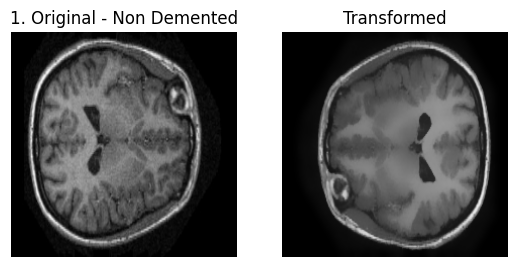

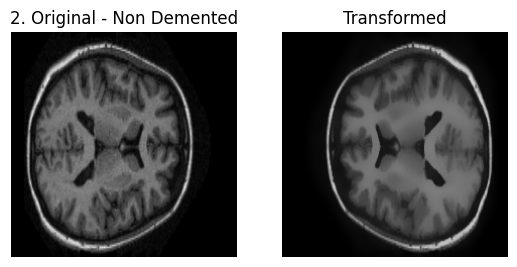

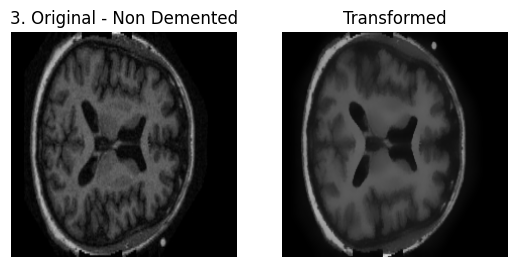

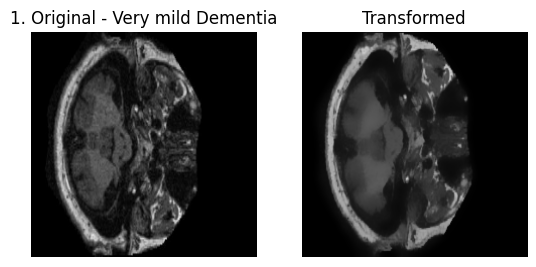

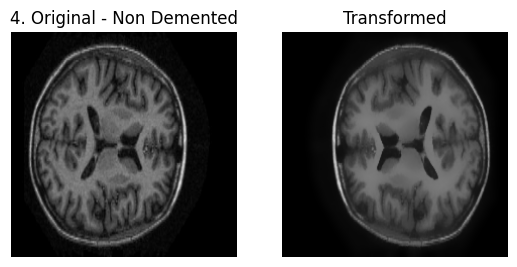

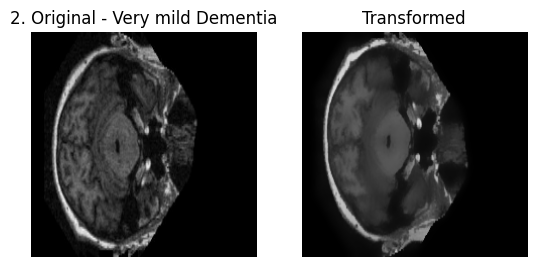

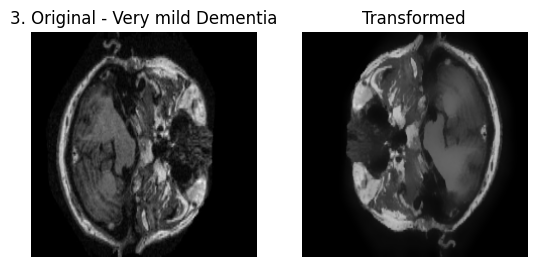

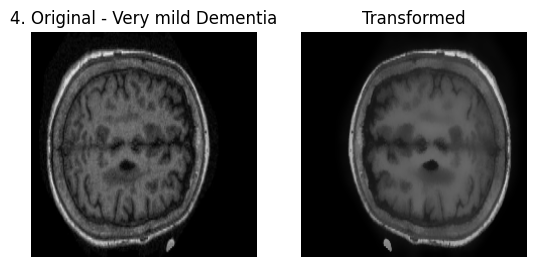

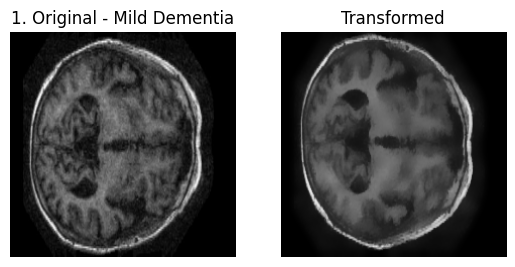

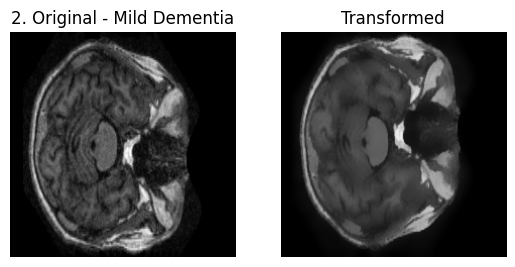

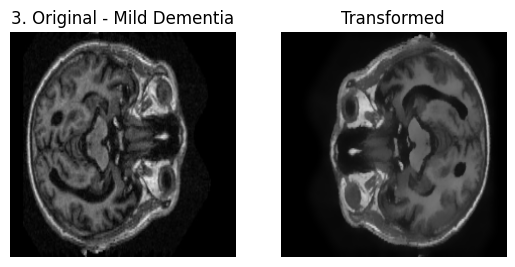

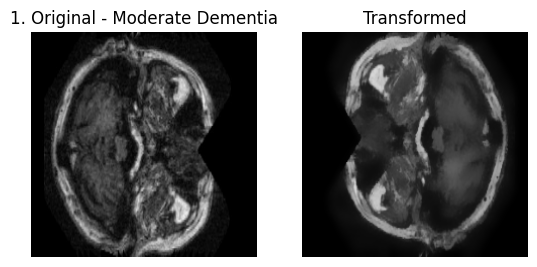

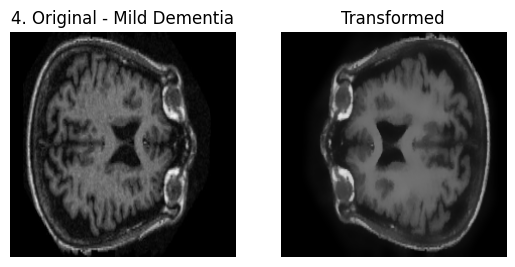

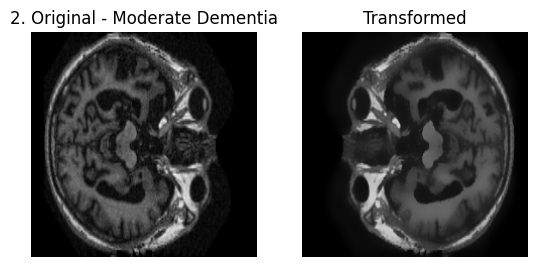

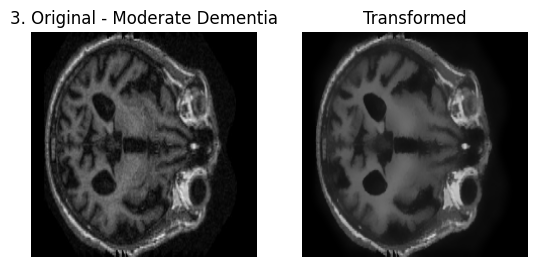

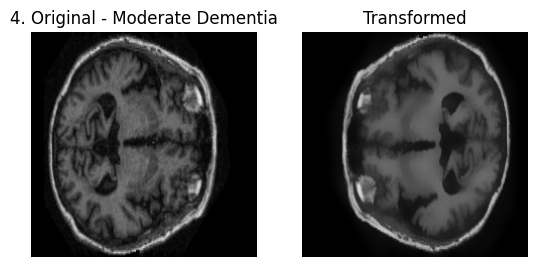

search reached defaultdict(<function OASISTorchDataset.show_sample_data.<locals>.<lambda> at 0x31f1aec10>, {'Non Demented': 4, 'Very mild Dementia': 4, 'Mild Dementia': 4, 'Moderate Dementia': 4})
Number of patients: 1417
Class Names: ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
Number of classes: 4
Minimum MRI waste for batch_size=13 is 0
Minimum MRI slices waste for batch_size=13 is 0
0 waste batch recommendations: [13, 109, 1417]


In [57]:
OASISTorchDataset.VOLUME_DEPTH = volume_depth
odd = OASISTFDataset()
train_ds, val_ds, test_ds = odd.tf_oasis_load_dataset(
    datasetdir,
    transforms=transforms,
    label_mode=task_type,
    class_names=None,
    color_mode=color_mode,
    batch_size=batch_size,
    ablation=ablation_study_size,
    image_size=(image_size, image_size),
    seed=random_seed,
    split_ratio_100=(70, 20, 10),
    dtype = f"float{precision}",
)

CLASS_NAMES = odd.classnames
num_classes = odd.num_classes
exit(1)

In [ ]:
class_weights = None
"class_weights", class_weights, "=============="

# Plot to Image and tensorboard logging

In [ ]:
import math, io
def plot_to_tfimage(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    print("Preparing matplotlib to tf-image...")
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def tf_image_grid(images, label):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    count, _, _, _ = images.shape
    n = int(math.sqrt(count))+1
    figure = plt.figure(figsize=(n*2,n*2))
    for i in range(count):
        ax = plt.subplot(n, n, i + 1)
        plt.imshow(images[i].numpy())
        if i == 0:
            plt.title(CLASS_NAMES[np.argmax(label)])
        plt.axis("off")
    return plot_to_tfimage(figure)

# define a tf image logger
tf_image_logger = tf.summary.create_file_writer(tf_log_img_dir)

def volume_viewer():
    for x_batch, y in train_ds: # train_ds, val_ds, test_ds
        lbl = y[0]
        tf_i = tf_image_grid(x_batch[0], lbl)
        with tf_image_logger.as_default():
            tf.summary.image(f"Input-sample-{volume_depth}", tf_i, step=0)
        plt.figure(figsize=[10, 10])
        plt.imshow(tf_i.numpy()[0])
        plt.axis("off")
        plt.title("Multiview MRI")
        plt.show()
        break
volume_viewer()
# # example use
# with tf_image_logger.as_default():
#     tf.summary.image("Image Sample", tf_img, step=0)

# Logger and Callbacks

In [ ]:
# CSV Logger
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback, Callback, LearningRateScheduler
import shutil, glob

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", 
                               mode="min", 
                               patience=7, 
                               min_delta=0.001,
                               verbose=1,
                               start_from_epoch=9,
                               restore_best_weights=True)

csv_logger = CSVLogger(artifact_root + '/metrics.csv')
# Tensorboard Logger
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tf_log_dir,
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None    
)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + "/models/epoch={epoch:02d}%s"%model_ext,
    monitor=monitor,
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

model_best_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + f"/models/best-model{model_ext}",
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

class BestModelEpochTrackerCallback(Callback):
    """
    This callback monitor best values and updates in a json file project_dir/bestvalue.json
    """
    def __init__(self, monitor, mode, initial_value_threshold=None, verbose=0):
        assert mode in ("min", "max")
        initial_thresh = initial_value_threshold
        self.monitor = monitor
        self.mode = mode
        self.best_value = initial_thresh
        if mode == "min":
            self.is_better = np.less
            if self.best_value is None:
                self.best_value = np.Inf
        elif mode == "max":
            self.is_better = np.greater
            if self.best_value is None:
                self.best_value = -np.Inf 
        self.verbose = verbose
        
    def on_epoch_end(self, epoch, metrics=None):
        curr_val = metrics.get(self.monitor, None)
        assert curr_val is not None, f"Unable to find the metric to monitor: {self.monitor}"
        if self.is_better(curr_val, self.best_value):
            update_path = artifact_root + "/bestvalue.json"
            if self.verbose:
                print(f"Epoch {epoch+1}: {self.monitor} improved form {self.best_value:.5f} to {curr_val:.5f} and saving updates to {update_path}")
            self.best_value = curr_val
            with open(update_path, "w") as fp:
                json.dump(dict(epoch=epoch+1, 
                               monitor=self.monitor, 
                               value=curr_val, 
                               mode=self.mode, 
                               frequency="epoch"
                              ), fp, indent=4)
        else:
            if self.verbose:
                self.print(f"Epoch {epoch+1}: {self.monitor} did not improved form {self.best_value}")
            
                

bestval_monitor_callback = BestModelEpochTrackerCallback(
    monitor=monitor,
    mode=mode,
    initial_value_threshold=initial_threshold,
)


class CleanupCallback(Callback):
    def on_epoch_end(self, epoch, metrics=None):
        return
        import gc
        gc.collect()
        
    def on_epoch_begin(self, epoch, metrics=None):
        # clean last checkpoint assets
        last_epoch = epoch - 1
        # update current
        with open(artifact_root + "/currentepoch.txt", "w") as fp:
            fp.write(f"{epoch}")
        # look for last epoch checkpoint and delete
        pattern = artifact_root + f"/models/epoch=%02d{model_ext}" % (last_epoch)
        try:
            if os.path.exists(pattern):
                os.remove(pattern)
        except:
            pass
       
        
        
cleanup_callback = CleanupCallback()
lr_callback = LearningRateScheduler(lr_schedule)

callbacks = []
if lr_schedular:
    callbacks.extend([lr_callback])

callbacks.extend([csv_logger, tensorboard_callback, model_ckpt, model_best_ckpt, bestval_monitor_callback, cleanup_callback])

if early_stop:
    callbacks.extend([early_stopping])


In [ ]:
import keras.applications


def create_multiview_mobilenet(input_shape, num_views, num_classes, trainable=False):
    """
    Creates a multiview CNN model using MobileNet as the base.

    Args:
        input_shape: Tuple, shape of each input image (e.g., (224, 224, 3)).
        num_views: Integer, number of input views.
        num_classes: Integer, number of output classes.

    Returns:
        A Keras Model instance.
    """
    input_tensor = keras.Input(shape=(num_views, *input_shape), name="multi_view_input")

    # Distribute the input to different branches for each view
    def distribute_views(views):
        unstacked_views = tf.split(views, num_views, axis=1, name="view_input_")
        unstacked_views = [tf.squeeze(t, axis=1) for t in unstacked_views]
        return unstacked_views

    distributed_input = keras.layers.Lambda(distribute_views, name="distribute_view_input")(input_tensor)
    # distributed_input = [keras.Input(shape=input_shape) for _ in range(num_views)]

    # Create a list to store the outputs of each view's MobileNet
    mobilenet_outputs = []

    # Create and apply MobileNet to each view
    for i in range(num_views):
        base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
        setattr(base_model, '_name', f"{base_model.name}_view_{i}")
        base_model.trainable = trainable  # Freeze base model weights
        x = base_model(distributed_input[i])
        mobilenet_outputs.append(x)

    # Concatenate the outputs of all views
    merged_features = keras.layers.Concatenate(axis=-1)(mobilenet_outputs)

    # Add custom layers on top of the concatenated features
    x = keras.layers.Conv2D(256, (3, 3), activation='relu')(merged_features)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile the final model
    model = keras.Model(inputs=input_tensor, outputs=outputs)
    return model

# Model Multiview build

In [ ]:
# Define the model
def prepare_model():
    global image_size, image_size, n_ch, volume_depth, num_classes, trainable, learning_rate, distributed
    import tensorflow as tf
    # EACH LINK CONTAINS AVAILABLE OPTIONS
    # Link: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # CHANGE HERE
    # Link: https://www.tensorflow.org/api_docs/python/tf/keras/metrics#classes
    metrics = [tf.keras.metrics.Accuracy(), 
               tf.keras.metrics.Recall(), 
               tf.keras.metrics.Precision(),
               tf.keras.metrics.F1Score(average="macro"),
               tf.keras.metrics.SensitivityAtSpecificity(0.6),
               tf.keras.metrics.SpecificityAtSensitivity(0.6)
              ]

    log("Building model...")
    import keras
    mvmodel = create_multiview_mobilenet((image_size, image_size, n_ch), volume_depth, 
                                         num_classes, trainable=trainable)
    
    # Compile the model
    log("Compile model")
    mvmodel.compile(optimizer=optimizer, loss=loss_function, metrics=metrics, 
                    run_eagerly=True)
    return mvmodel, optimizer, metrics

def get_dummy_dataset():
    global volume_depth, image_size, image_size, n_ch, num_classes
    items = 1
    features = tf.random.normal((items, volume_depth, image_size, image_size, n_ch))
    labels = tf.ones(shape=(items, num_classes))
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    return dataset.batch(1)

import gc
gc.collect()

# Create a strategy to distribute training across CPU and GPU
if distributed:
    print("Distributed trainig is enabled")
    import tensorflow as tf, keras
    strategy = tf.distribute.MirroredStrategy(devices)
    with strategy.scope():
        mvmodel, optimizer, metrics = prepare_model()
else:
    mvmodel, optimizer, metrics = prepare_model()

print("Printing model summary...")
mvmodel.summary()
model_lenet = mvmodel

In [ ]:
# Warm-up the strategy by performing a single training step
print("Running warm-up step training...")
dummy_data = get_dummy_dataset()
print("Dummy dataset is prepared for warm-up.")
mvmodel.fit(dummy_data, validation_data=dummy_data,batch_size=batch_size, epochs=1, steps_per_epoch=1)
print("Model warm-up is done.")

# Saving parameters 

In [ ]:
# reload checkpoint
if resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
    log("Resuming training...", resume_checkpoint_path)
    model_lenet.load_weights(resume_checkpoint_path)
else:
    log("Fresh training...")
    initial_epoch = 0
# daving hyper-params
save_hparams()

# Training

In [ ]:
# Train the model
log("Experiment: Started", time=True)
log(f"Starting training model={model_name}")
history = model_lenet.fit(train_ds, validation_data=val_ds,
                          epochs=max_epoch,
                          initial_epoch=initial_epoch, 
                          callbacks = callbacks,
                          class_weight=class_weights,
                          batch_size=batch_size,
                          max_queue_size=3,
                         )
log(f"Training done={model_name}")

In [ ]:
# Evaluate the model on the test set
best_model = artifact_root + f"/models/best-model{model_ext}"
if os.path.exists(best_model):
    log("Loading best model...", best_model)
    model_lenet.load_weights(best_model)
log("Experiment: Evaluating", time=True)
log(f"Evaluating model={model_name}...")
test_result = model_lenet.evaluate(test_ds)

In [ ]:
# class LossMetric(tf.keras.metrics.Metric):
#     def __init__(self, name='loss', **kwargs):
#         super().__init__(name='loss', **kwargs)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         pass

#     def result(self):
#         return 0

In [ ]:
metrics_name = [k.name for k in metrics]
metrics_name.insert(0, 'loss')

log(f"{model_name}", {f"test_{k}":v for v,k in zip(test_result, metrics_name)})

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    for v, k in zip(test_result, metrics):
        tf.summary.scalar(f"test_{k.name}", v, step=0)

In [ ]:
def prepare_prediction_df(ds):
    records = []
    for imgs, lbls in ds:
        proba_lbls = model_lenet.predict(imgs)
        actual = odd.decode_labels(lbls.numpy())
        predicted = odd.decode_labels(proba_lbls)
        records.extend(np.array([actual, predicted]).T.tolist())
    return pd.DataFrame(records, columns=['actual', 'predicted'])

train_df = prepare_prediction_df(train_ds)
val_df = prepare_prediction_df(val_ds)
test_df = prepare_prediction_df(test_ds)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def analyse_result(df, prefix):
    try:
        print(f"======================{prefix}=========================")
        y_true = df['actual']
        y_pred = df['predicted']
    
        # prepare confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        df = pd.DataFrame(cm, columns=CLASS_NAMES, index=CLASS_NAMES)
        # prepare confusion matrix heatmap
        figure = plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=CLASS_NAMES, 
                     yticklabels=CLASS_NAMES)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{prefix} Confusion Matrix')
        plt.show()
        # prepare classification report
        report = classification_report(y_true, y_pred)
    
        # log heatmap to tensorboard
        with tf_image_logger.as_default():
            tf_i = plot_to_tfimage(figure)
            tf.summary.image(f"{prefix} Confusion Matrix-Heatmap", tf_i, step=0)
        # log reports to tensorboard
        file_writer = tf.summary.create_file_writer(tf_log_dir)
        with file_writer.as_default():
            tf.summary.text(f"{prefix} Confusion Matrix", df.to_string(), step=0)
            tf.summary.text(f"{prefix} classification report", report, step=0)
        
        # log into file
        log(f"{prefix} Confusion Matrix: actual(row) vs predicted(cols)")
        log(df.to_string())
        log(f"{prefix} Classification report")
        log(report)
    
        # log artifacts to the directory
        df.to_csv(artifact_root + f'/{prefix}_confusion-matrix.csv')
        with open(artifact_root + f'/{prefix}_classification_report.txt', "w") as fp:
            fp.write(report)
    except:
        print("The dataset does not have all the classes")

analyse_result(train_df, "Training")
analyse_result(val_df, "Validation")
analyse_result(test_df, "Testing")

In [ ]:
from PIL import Image
def preprocess_image(image_path):
    # Open the image file
    img_array, lbl, cls_name = odd.sample_dataset.get_volume_for_image(image_path)
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    return img_array


# Example usage:
actual_class = TEST_IMG_LABEL
image_path = TEST_IMG_PATH
image_array = preprocess_image(image_path)
log("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
log("Experiment: Testing", time=True)
prediction_probabilities = model_lenet.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labelsa
class_labels = CLASS_NAMES

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    tf.summary.text(f"Corner Case", f"Actual={actual_class} Predicted={predicted_class}", step=0)

log("Actual class:", actual_class)
log("Predicted class:", predicted_class)
log("Experiment: Completed", time=True)

In [ ]:
log(f"Your result is saved at: '{artifact_root}'")